# 1. Data Acquisition

In [25]:
!pip install sentinelhub

  Obtaining dependency information for sentinelhub from https://files.pythonhosted.org/packages/09/25/8073910d195d4557320cfc48885b40a47d5c0148ca3297164a2aee35e809/sentinelhub-3.10.0-py3-none-any.whl.metadata
  Obtaining dependency information for aenum>=2.1.4 from https://files.pythonhosted.org/packages/d0/fa/ca0c66b388624ba9dbbf35aab3a9f326bfdf5e56a7237fe8f1b600da6864/aenum-3.1.15-py3-none-any.whl.metadata
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.4/245.4 kB 2.5 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 10.9 MB/s eta 0:00:00
  Created wheel for utm: filename=utm-0.7.0-py3-none-any.whl size=6085 sha256=e691cb549a06292d0359e3626665d5a261cab7530b5927148689bac5a38dac62
  Stored in directory: /root/.cache/pip/wheels/2f/a1/c8/543df0e8f5e824c3e92a432e32deb9cd89ae686095ee8cfcbe
Successfully built utm


In [26]:
CLIENT_ID = '<id-here>'
CLIENT_SECRET = '<secret-here>'

In [27]:
from sentinelhub import SHConfig

config = SHConfig()

config.sh_client_id = CLIENT_ID
config.sh_client_secret = CLIENT_SECRET

if not config.sh_client_id or not config.sh_client_secret:
  print('Please provide credentials to use Process API.')

**Importing Libraries**

In [28]:
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    Geometry
)

## 1.1 Getting Sentinel-2 Data

### Defining Region of Interest

In [29]:
coords = (-80.68715353939942, 43.5306092687972, -80.31361838314942, 43.73139417849985)

resolution = 25

bbox = BBox(bbox=coords, crs=CRS.WGS84)
image_size = bbox_to_dimensions(bbox, resolution=resolution)

print(f'Image shape at {resolution} m resolution: {image_size}')

Image shape at 25 m resolution: (1200, 899)


### Getting Images

In [30]:
import datetime

start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2021, 12, 31)
n_chunks = 49
tdelta = (end - start) / n_chunks
edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]

print("Monthly time windows:\n")
i=1
for slot in slots:
    print({i}, slot)
    i+=1

Monthly time windows:

{1} ('2018-01-01', '2018-01-30')
{2} ('2018-01-30', '2018-03-01')
{3} ('2018-03-01', '2018-03-31')
{4} ('2018-03-31', '2018-04-30')
{5} ('2018-04-30', '2018-05-29')
{6} ('2018-05-29', '2018-06-28')
{7} ('2018-06-28', '2018-07-28')
{8} ('2018-07-28', '2018-08-27')
{9} ('2018-08-27', '2018-09-26')
{10} ('2018-09-26', '2018-10-25')
{11} ('2018-10-25', '2018-11-24')
{12} ('2018-11-24', '2018-12-24')
{13} ('2018-12-24', '2019-01-23')
{14} ('2019-01-23', '2019-02-22')
{15} ('2019-02-22', '2019-03-23')
{16} ('2019-03-23', '2019-04-22')
{17} ('2019-04-22', '2019-05-22')
{18} ('2019-05-22', '2019-06-21')
{19} ('2019-06-21', '2019-07-21')
{20} ('2019-07-21', '2019-08-19')
{21} ('2019-08-19', '2019-09-18')
{22} ('2019-09-18', '2019-10-18')
{23} ('2019-10-18', '2019-11-17')
{24} ('2019-11-17', '2019-12-17')
{25} ('2019-12-17', '2020-01-15')
{26} ('2020-01-15', '2020-02-14')
{27} ('2020-02-14', '2020-03-15')
{28} ('2020-03-15', '2020-04-14')
{29} ('2020-04-14', '2020-05-14')


In [31]:
evalscript = """
//VERSION=3

function setup() {
  return {
    input: ["B02", "B03", "B04"],
    output: { bands: 3 }
  };
}

function evaluatePixel(sample) {
  return [2.5 * sample.B04, 2.5 * sample.B03, 2.5 * sample.B02];
}
"""

In [32]:
def get_true_color_request(time_interval):
    return SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,          
                time_interval=('2018-01-01', '2021-12-31'),          
                other_args={"dataFilter": {"mosaickingOrder": "leastCC"}}
            ),
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.JPG),
        ],
        bbox=bbox,
        size=[512, 379.602],
        config=config
    )

In [33]:
# create a list of requests
list_of_requests = [get_true_color_request(slot) for slot in slots]
list_of_requests = [request.download_list[0] for request in list_of_requests]

# download data with multiple threads
data = SentinelHubDownloadClient(config=config).download(list_of_requests, max_threads=5)

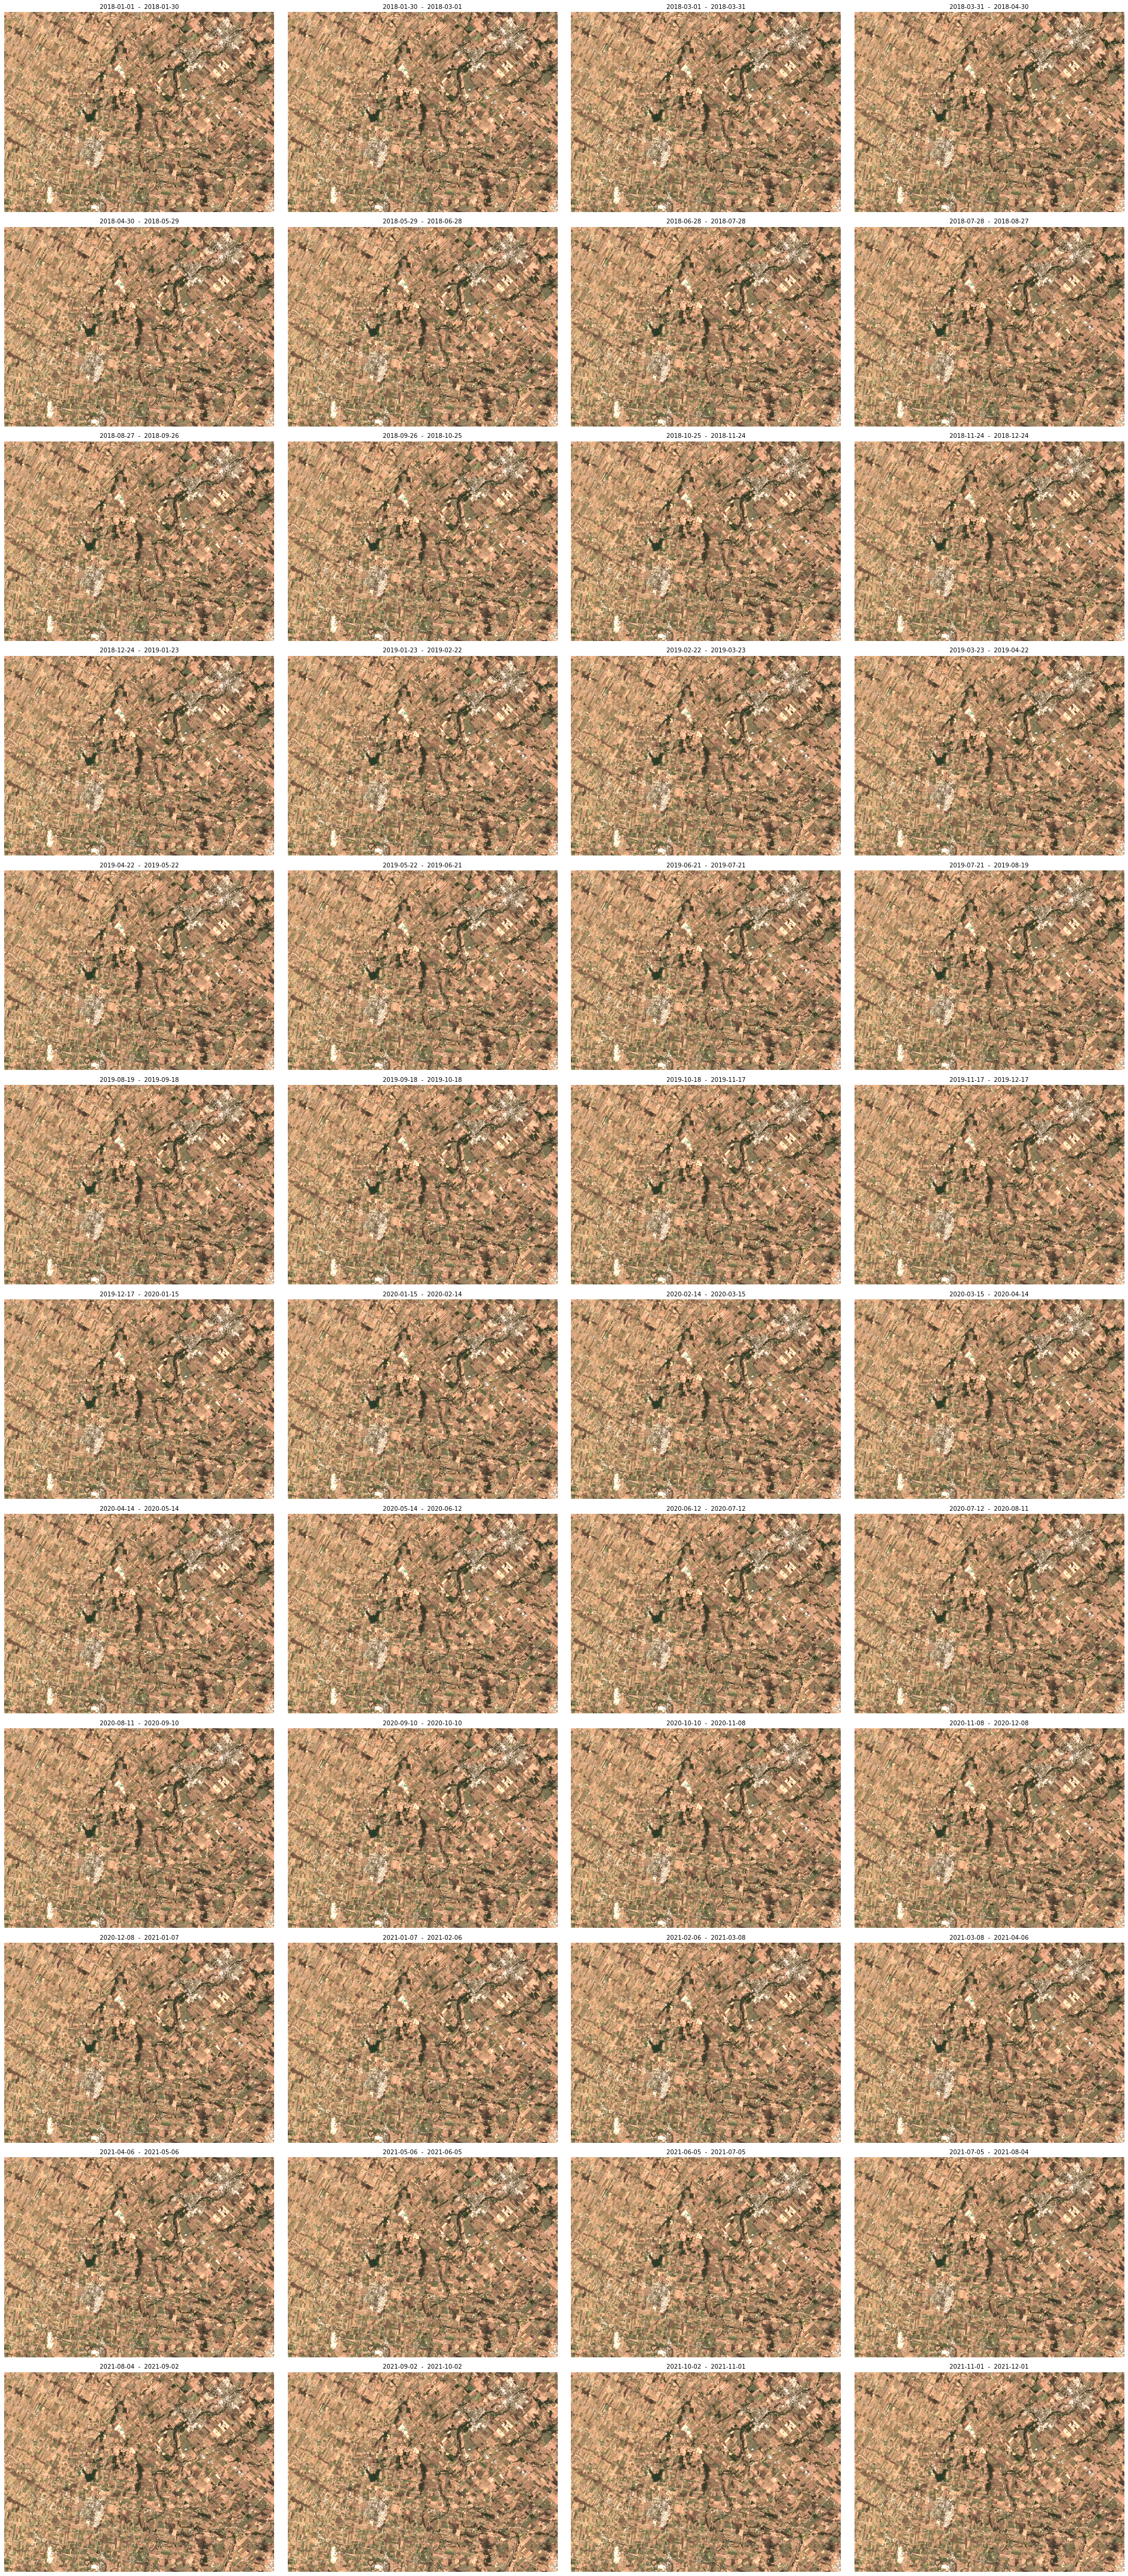

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# some stuff for pretty plots
ncols = 4
nrows = 12
aspect_ratio = image_size[0] / image_size[1]
subplot_kw = {"xticks": [], "yticks": [], "frame_on": False}

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(5 * ncols * aspect_ratio, 5 * nrows), subplot_kw=subplot_kw)

for idx, image in enumerate(data):
    ax = axs[idx // ncols][idx % ncols]
    ax.imshow(np.clip(image * 2.5 / 255, 0, 1))
    ax.set_title(f"{slots[idx][0]}  -  {slots[idx][1]}", fontsize=10)

plt.tight_layout()

### Checking shape of the images

In [34]:
import numpy as np

# Assuming 'data' is a list or array of images
for i, image in enumerate(data):
    # Convert the image to a NumPy array
    np_array = np.array(image)

    # Get the shape of the array (which corresponds to the shape of the image)
    shape = np_array.shape

    # Print the shape of the image
    print(f"Image {i + 1}: Shape = {shape}")


Image 1: Shape = (379, 512, 3)
Image 2: Shape = (379, 512, 3)
Image 3: Shape = (379, 512, 3)
Image 4: Shape = (379, 512, 3)
Image 5: Shape = (379, 512, 3)
Image 6: Shape = (379, 512, 3)
Image 7: Shape = (379, 512, 3)
Image 8: Shape = (379, 512, 3)
Image 9: Shape = (379, 512, 3)
Image 10: Shape = (379, 512, 3)
Image 11: Shape = (379, 512, 3)
Image 12: Shape = (379, 512, 3)
Image 13: Shape = (379, 512, 3)
Image 14: Shape = (379, 512, 3)
Image 15: Shape = (379, 512, 3)
Image 16: Shape = (379, 512, 3)
Image 17: Shape = (379, 512, 3)
Image 18: Shape = (379, 512, 3)
Image 19: Shape = (379, 512, 3)
Image 20: Shape = (379, 512, 3)
Image 21: Shape = (379, 512, 3)
Image 22: Shape = (379, 512, 3)
Image 23: Shape = (379, 512, 3)
Image 24: Shape = (379, 512, 3)
Image 25: Shape = (379, 512, 3)
Image 26: Shape = (379, 512, 3)
Image 27: Shape = (379, 512, 3)
Image 28: Shape = (379, 512, 3)
Image 29: Shape = (379, 512, 3)
Image 30: Shape = (379, 512, 3)
Image 31: Shape = (379, 512, 3)
Image 32: Shape =

# 2. Data Preparation

## 2.1 Aggregating Data

In [35]:
# Define years and months for aggregation
years = [2018, 2019, 2020, 2021]
skip_months = [1, 2, 12]

# Placeholder for date information
date_info = [(2018, 1), (2018, 2), (2018, 3), (2018, 4), (2018, 5), (2018, 6), (2018, 7), (2018, 8), (2018, 9), (2018, 10), (2018, 11), (2018, 12),
            (2019, 1), (2019, 2), (2019, 3), (2019, 4), (2019, 5), (2019, 6), (2019, 7), (2019, 8), (2019, 9), (2019, 10), (2019, 11), (2019, 12),
            (2020, 1), (2020, 2), (2020, 3), (2020, 4), (2020, 5), (2020, 6), (2020, 7), (2020, 8), (2020, 9), (2020, 10), (2020, 11), (2020, 12),
            (2021, 1), (2021, 2), (2021, 3), (2021, 4), (2021, 5), (2021, 6), (2021, 7), (2021, 8), (2021, 9), (2021, 10), (2021, 11), (2021, 12)]

# Aggregate data function
def aggregate_data(data, date_info, years, skip_months):
    aggregated_data = {}
    for year in years:
        for month in range(1, 13):
            if month not in skip_months:
                # Filter data for the specific year and month
                monthly_data = [data[i] for i, (img_year, img_month) in enumerate(date_info) if img_year == year and img_month == month]
                # Store the aggregated data
                aggregated_data[(year, month)] = monthly_data
    return aggregated_data

# Aggregate the data
aggregated_data = aggregate_data(data, date_info, years, skip_months)

# Show keys to verify the aggregation
list(aggregated_data.keys())



[(2018, 3),
 (2018, 4),
 (2018, 5),
 (2018, 6),
 (2018, 7),
 (2018, 8),
 (2018, 9),
 (2018, 10),
 (2018, 11),
 (2019, 3),
 (2019, 4),
 (2019, 5),
 (2019, 6),
 (2019, 7),
 (2019, 8),
 (2019, 9),
 (2019, 10),
 (2019, 11),
 (2020, 3),
 (2020, 4),
 (2020, 5),
 (2020, 6),
 (2020, 7),
 (2020, 8),
 (2020, 9),
 (2020, 10),
 (2020, 11),
 (2021, 3),
 (2021, 4),
 (2021, 5),
 (2021, 6),
 (2021, 7),
 (2021, 8),
 (2021, 9),
 (2021, 10),
 (2021, 11)]

In [14]:
# Display the images
def display_all_images(aggregated_data):
    # Get all keys from the dictionary
    keys = aggregated_data.keys()

    # Loop over each key
    for key in keys:
        year, month = key
        images = aggregated_data[key]

        print(f"Displaying images for {month}/{year}:")
        for i, image in enumerate(images):
            plt.figure(figsize=(5, 5))
            plt.imshow(image)
            plt.title(f"Image {i+1} - {month}/{year}")
            plt.axis('off')
            plt.show()

# Call the function with your aggregated data
# display_all_images(aggregated_data)


## 2.2 Organizing Spectral Bands

In [36]:
def organize_spectral_bands(aggregated_data):
    organized_data = {}

    for key, images in aggregated_data.items():
        organized_images = [organize_bands(img) for img in images]
        organized_data[key] = organized_images

    return organized_data

def organize_bands(image):
    # Keeping only the first three bands
    if image.shape[2] >= 3:
        return image[:, :, :3]
    else:
        return image

organized_data = organize_spectral_bands(aggregated_data)


In [16]:
# Display the images
def display_all_images(aggregated_data):
    # Get all keys from the dictionary
    keys = aggregated_data.keys()

    # Loop over each key
    for key in keys:
        year, month = key
        images = aggregated_data[key]

        print(f"Displaying images for {month}/{year}:")
        for i, image in enumerate(images):
            plt.figure(figsize=(5, 5))
            plt.imshow(image)
            plt.title(f"Image {i+1} - {month}/{year}")
            plt.axis('off')
            plt.show()

# Call the function with your organized data
# display_all_images(organized_data)


## 2.3 Interpolation

In [37]:
import numpy as np
from scipy.interpolate import interp1d

def interpolate_missing_data(organized_data):
    interpolated_data = {}

    # Loop over each location in the time series
    for key in organized_data:
        year, month = key
        images = organized_data[key]

        # Check if interpolation is needed
        if len(images) > 1 and is_interpolation_needed(images):
            interpolated_images = temporal_interpolation(images)
        else:
            interpolated_images = images

        interpolated_data[key] = interpolated_images

    return interpolated_data

def is_interpolation_needed(images):
    # Determine if interpolation is needed
    return np.any(np.isnan(np.array(images)))

def temporal_interpolation(images):
    # Perform temporal interpolation for each pixel
    # Linear interpolation
    time_steps = len(images)
    height, width, bands = images[0].shape

    interpolated_images = []

    for b in range(bands):
        # Create a 2D array for each band, with time as the first dimension
        band_data = np.array([img[:, :, b] for img in images])

        for i in range(height):
            for j in range(width):
                if np.isnan(band_data[:, i, j]).any():
                    # Interpolate for this pixel across time
                    valid_times = np.nonzero(~np.isnan(band_data[:, i, j]))[0]
                    if valid_times.size > 1:
                        interp_func = interp1d(valid_times, band_data[valid_times, i, j], 
                                               kind='linear', fill_value="extrapolate")
                        band_data[:, i, j] = interp_func(np.arange(time_steps))

        # Reconstruct the image with interpolated band
        for t in range(time_steps):
            if t >= len(interpolated_images):
                interpolated_images.append(np.zeros((height, width, bands)))
            interpolated_images[t][:, :, b] = band_data[t]

    return interpolated_images

interpolated_data = interpolate_missing_data(organized_data)


## 2.4 Stacking Images

In [38]:
import os
import tifffile as tiff
import numpy as np

# Specify the folder to save the stacked images
output_folder = "stacked_images"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Create a dictionary to store stacked images by year
stacked_images = {}

# Iterate through the interpolated_data dictionary and stack images by year
for (year, month), image_3d in interpolated_data.items():
    # Check if the year is already in the stacked_images dictionary
    if year not in stacked_images:
        stacked_images[year] = [image_3d]
    else:
        stacked_images[year].append(image_3d)

# Save the stacked images as TIFF files, one per year
for year, images in stacked_images.items():
    # Stack the images along a new dimension to create a 4D image
    stacked_image = np.stack(images, axis=0)
    
    # Define the output TIFF filename for the stacked image
    output_filename = os.path.join(output_folder, f"{year}_stacked.tif")
    
    # Save the stacked image as a TIFF file
    tiff.imsave(output_filename, stacked_image)

/tmp/ipykernel_42/2043301725.py:31: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(output_filename, stacked_image)


### Checking shape of the stacked images

In [39]:
import tifffile as tiff

# List of years for which stacked images have been saved
years = [2018, 2019, 2020, 2021] 

# Iterate through the years and check the shape of the corresponding TIFF file
for year in years:
    tiff_file = f"/kaggle/working/stacked_images/{year}_stacked.tif"
    try:
        # Open the TIFF file
        stacked_image = tiff.imread(tiff_file)
        
        # Get the shape of the stacked image
        shape = stacked_image.shape
        
        # Print the shape
        print(f"Year {year}: Shape = {shape}")
    except Exception as e:
        print(f"Year {year}: Unable to read TIFF file or file does not exist")

Year 2018: Shape = (9, 1, 379, 512, 3)
Year 2019: Shape = (9, 1, 379, 512, 3)
Year 2020: Shape = (9, 1, 379, 512, 3)
Year 2021: Shape = (9, 1, 379, 512, 3)


### Displaying Stacked Images

In [20]:
# import os
# import matplotlib.pyplot as plt
# from matplotlib.image import imread

# # Specify the folder containing the stacked images
# stacked_images_folder = "stacked_images"

# # Iterate through the images in the folder and display each one
# for filename in os.listdir(stacked_images_folder):
#     if filename.endswith(".tif"):
#         # Construct the full path to the image
#         image_path = os.path.join(stacked_images_folder, filename)
        
#         # Read and display the image
#         image = imread(image_path)
#         plt.imshow(image)
#         plt.axis('off')  # Turn off axis labels
#         plt.show()

### Checking shape of the ground truth images

In [40]:
import tifffile as tiff

# List of years for which you have saved stacked images
years = [2018, 2019, 2020, 2021] 

# Iterate through the years and check the shape of the corresponding TIFF file
for year in years:
    tiff_file = f"/kaggle/input/ground-data/{year}.tif"
    try:
        # Open the TIFF file
        stacked_image = tiff.imread(tiff_file)
        # Get the shape of the stacked image
        shape = stacked_image.shape
        
        # Print the shape
        print(f"Year {year}: Shape = {shape}")
    except Exception as e:
        print(f"Year {year}: Unable to read TIFF file or file does not exist")

Year 2018: Shape = (933, 1137)
Year 2019: Shape = (933, 1137)
Year 2020: Shape = (933, 1137)
Year 2021: Shape = (933, 1137)


### Removing the singleton dimension

In [41]:
import os
import tifffile as tiff
import numpy as np
import shutil

# Specify the folder to save the stacked images
output_folder = "stacked_images_updated"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Create a dictionary to store stacked images by year
stacked_images = {}

# Iterate through the interpolated_data dictionary and stack images by year
for (year, month), image_3d in interpolated_data.items():
    # Check if the year is already in the stacked_images dictionary
    if year not in stacked_images:
        stacked_images[year] = [image_3d]
    else:
        stacked_images[year].append(image_3d)

# Save the stacked images as TIFF files, one per year
for year, images in stacked_images.items():
    # Stack the images along a new dimension to create a 4D image
    stacked_image = np.stack(images, axis=0)
    
    # Remove the singleton dimension along the second axis
    stacked_image = np.squeeze(stacked_image, axis=1)
    
    # Define the output TIFF filename for the stacked image
    output_filename = os.path.join(output_folder, f"{year}_stacked.tif")
    
    # Save the stacked image as a TIFF file
    tiff.imsave(output_filename, stacked_image)


/tmp/ipykernel_42/2009790174.py:35: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(output_filename, stacked_image)


### Checking shape of the updated images

In [42]:
import tifffile as tiff

# List of years for which you have saved stacked images
years = [2018, 2019, 2020, 2021]

# Iterate through the years and check the shape of the corresponding TIFF file
for year in years:
    tiff_file = f"/kaggle/working/stacked_images_updated/{year}_stacked.tif"
    try:
        # Open the TIFF file
        stacked_image = tiff.imread(tiff_file)
        
        # Get the shape of the stacked image
        shape = stacked_image.shape
        
        # Print the shape
        print(f"Year {year}: Shape = {shape}")
    except Exception as e:
        print(f"Year {year}: Unable to read TIFF file or file does not exist")

Year 2018: Shape = (9, 379, 512, 3)
Year 2019: Shape = (9, 379, 512, 3)
Year 2020: Shape = (9, 379, 512, 3)
Year 2021: Shape = (9, 379, 512, 3)


### Displating the updated images

In [24]:
# import os
# import matplotlib.pyplot as plt
# from matplotlib.image import imread

# # Specify the folder containing the stacked images
# stacked_images_folder = "stacked_images"

# # Iterate through the images in the folder and display each one
# for filename in os.listdir(stacked_images_folder):
#     if filename.endswith(".tif"):
#         # Construct the full path to the image
#         image_path = os.path.join(stacked_images_folder, filename)
        
#         # Read and display the image
#         image = imread(image_path)
#         plt.imshow(image)
#         plt.axis('off')  # Turn off axis labels
#         plt.show()

## 2.5 Masking Data

In [43]:
pip install patchify

Note: you may need to restart the kernel to use updated packages.


In [44]:
from scipy import stats
import os
from skimage import io
from skimage import color
import cv2
from patchify import patchify
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from skimage.io import imread
from skimage import img_as_ubyte

In [45]:
# Function for loading and resizing image
def load_and_resize(image_path, size):
    if isinstance(image_path, np.ndarray):
        # If the input is a NumPy array, create a Pillow image from the array
        image = Image.fromarray(image_path)
    else:
        # If the input is a file path, open the image using Pillow
        image = Image.open(image_path)

    # Convert the image to a NumPy array
    image = np.array(image)

    # Check if the image has multiple stacks
    if len(image.shape) == 4:
        # Process all the images in each stack
        processed_images = []
        for i in range(image.shape[0]):
            single_image = image[i]
            single_image_resized = cv2.resize(single_image, (size[1], size[0]), interpolation=cv2.INTER_NEAREST)
            processed_images.append(single_image_resized)
        return np.array(processed_images)
    else:
        # Resize the single image using the dimensions from the 'size' tuple
        image_resized = cv2.resize(image, (size[1], size[0]), interpolation=cv2.INTER_NEAREST)
        return np.expand_dims(image_resized, axis=0)

In [46]:
# Function for creating patches of the satellite images
def create_patches(image, patch_size):
    patches_list = []
    step_size = int(0.75 * patch_size)  # sliding window with 25% overlap
    if len(image.shape) == 3:
        patches = patchify(image, (patch_size, patch_size, 3), step=step_size)
        for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                single_patch_img = patches[i, j, :, :]
                single_patch_img = single_patch_img[0]  # Drop the extra unnecessary dimension that patchify adds.
                patches_list.append(single_patch_img)
                patch_data = np.array(patches_list)
    else:
        patches = patchify(image, (patch_size, patch_size), step=step_size)

        for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                single_patch_img = patches[i, j, :, :]
                # single_patch_img = single_patch_img[0]
                patches_list.append(single_patch_img)
                patch_data = np.array(patches_list)

    return patch_data

In [47]:
# Function For Label extraction from ground truth image for the entire training image
def assign_label(image, labels, thresholds):
    label_counts = [np.count_nonzero(image == label) for label in labels]
    total_pixels = image.shape[0] * image.shape[1]
    label_fractions = [count / total_pixels for count in label_counts]

    for label_fraction, label, threshold in zip(label_fractions, labels, thresholds):
        if label_fraction >= threshold:
            return label
    return stats.mode(image, axis=None)[0]

In [48]:
# Function for applying all the operations and returning labeled image
# ...

# Function for applying all the operations and returning labeled image
def process_images(training_image_path, ground_truth_path, labels, thresholds):
    # Loading Images
    training_image = imread(training_image_path)
    ground_truth = load_and_resize(ground_truth_path, training_image.shape[1:3])

    # Print the paths and shapes for debugging
    print(f"Training image path: {training_image_path}, Ground truth path: {ground_truth_path}")
    print(f"Training image shape: {training_image.shape}, Ground truth shape: {ground_truth.shape}")

    # Ensure that both images have the same shape (height, width)
    if training_image.shape[1:3] != ground_truth.shape[1:3]:
        raise ValueError("Training image and ground truth image must have the same dimensions.")

    # Check if the training image is grayscale or color
    if len(training_image.shape) == 4:
        # Process all the stacks in the training image
        processed_images = []
        for i in range(training_image.shape[0]):
            single_stack = training_image[i]
            single_stack_resized = load_and_resize(single_stack, training_image.shape[1:3])
            processed_images.append(single_stack_resized)
        training_image_resized = np.array(processed_images)
    else:
        # Resize the single image using the dimensions from the 'size' tuple
        training_image_resized = load_and_resize(training_image, training_image.shape[1:3])

    plt.figure(1)
    plt.imshow(ground_truth[0], cmap='tab20')  # Display the first stack of ground truth for visualization

    plt.figure(2)
    plt.imshow(training_image_resized[0][0])  # Display the first stack of resized training image for visualization
    print(f"Train Shape: {training_image_resized.shape} \nMask shape: {ground_truth.shape}")

    # Apply ground label and mask
    labeled_images = np.zeros_like(training_image_resized)
    for i in range(training_image_resized.shape[0]):
        mask = (ground_truth[0] > 0)  # Assuming the ground truth values greater than 0 are valid
        labeled_images[i][0][mask] = assign_label(training_image_resized[i][0][mask], labels, thresholds)

    return labeled_images

Training image path: /kaggle/working/stacked_images_updated/2018_stacked.tif, Ground truth path: /kaggle/input/ground-data/2018.tif
Training image shape: (9, 379, 512, 3), Ground truth shape: (1, 379, 512)
Train Shape: (9, 1, 379, 512, 3) 
Mask shape: (1, 379, 512)
Training image path: /kaggle/working/stacked_images_updated/2019_stacked.tif, Ground truth path: /kaggle/input/ground-data/2019.tif
Training image shape: (9, 379, 512, 3), Ground truth shape: (1, 379, 512)
Train Shape: (9, 1, 379, 512, 3) 
Mask shape: (1, 379, 512)
Training image path: /kaggle/working/stacked_images_updated/2020_stacked.tif, Ground truth path: /kaggle/input/ground-data/2020.tif
Training image shape: (9, 379, 512, 3), Ground truth shape: (1, 379, 512)
Train Shape: (9, 1, 379, 512, 3) 
Mask shape: (1, 379, 512)
Training image path: /kaggle/working/stacked_images_updated/2021_stacked.tif, Ground truth path: /kaggle/input/ground-data/2021.tif
Training image shape: (9, 379, 512, 3), Ground truth shape: (1, 379, 5

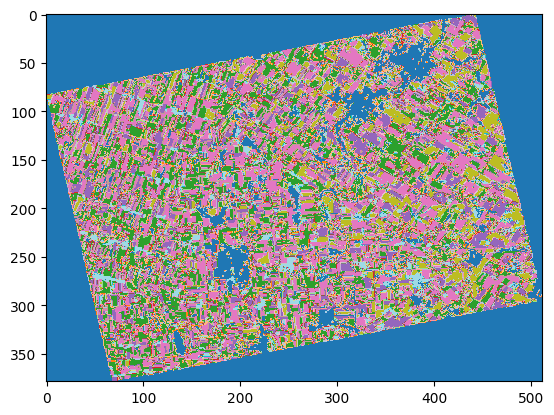

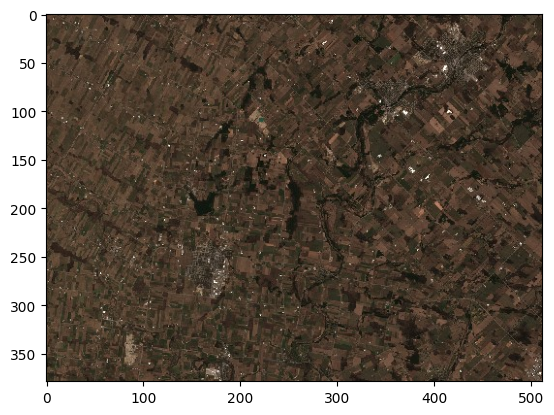

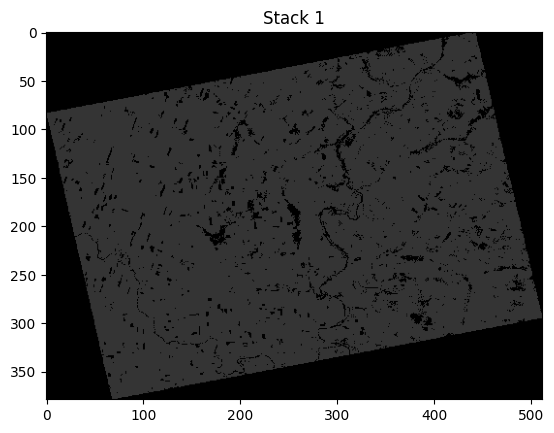

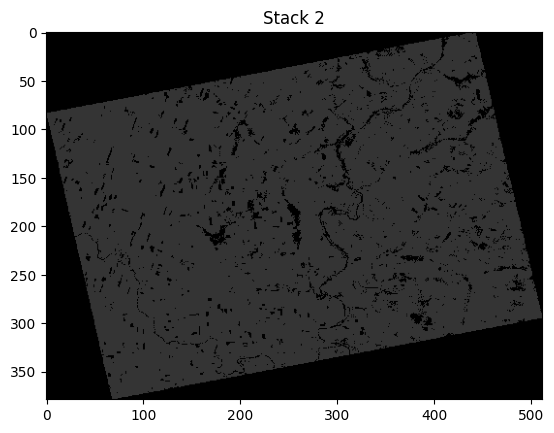

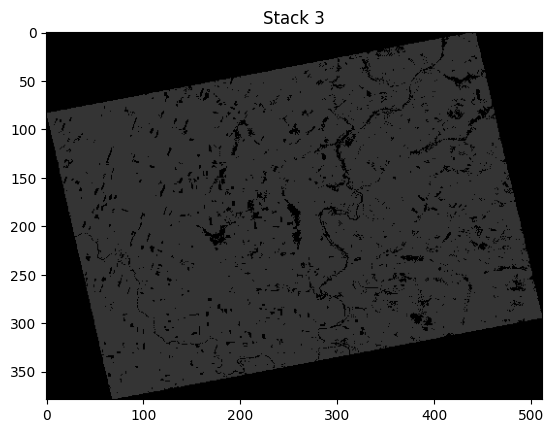

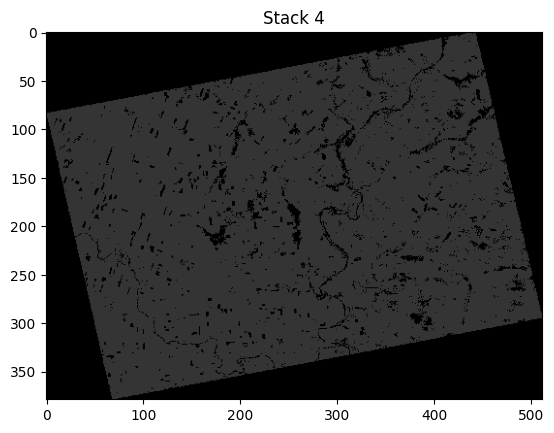

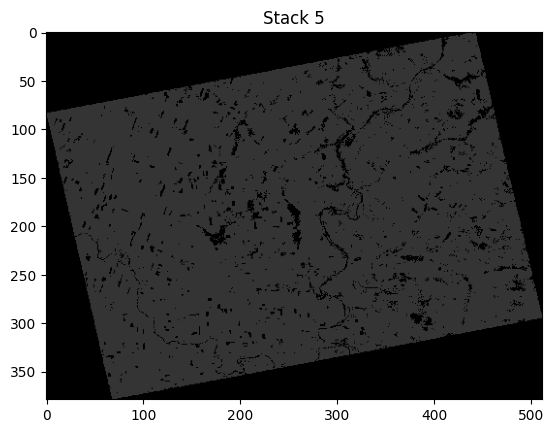

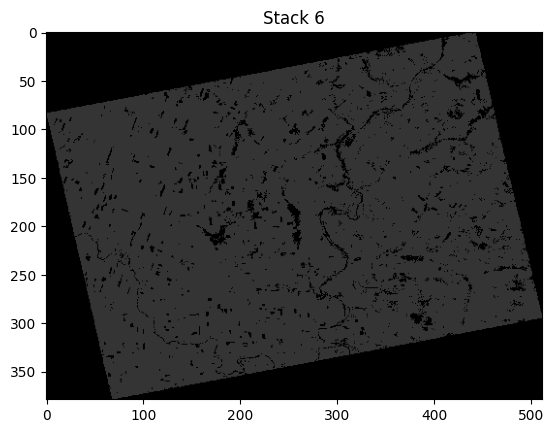

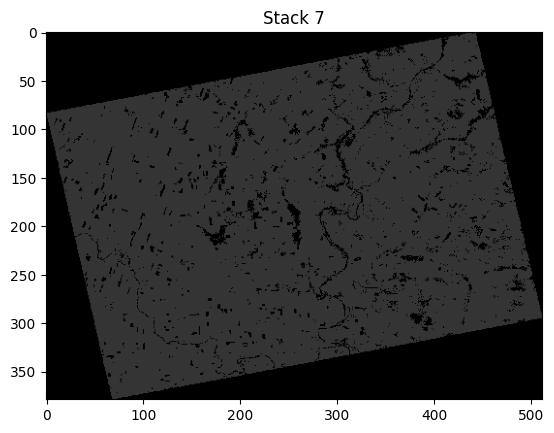

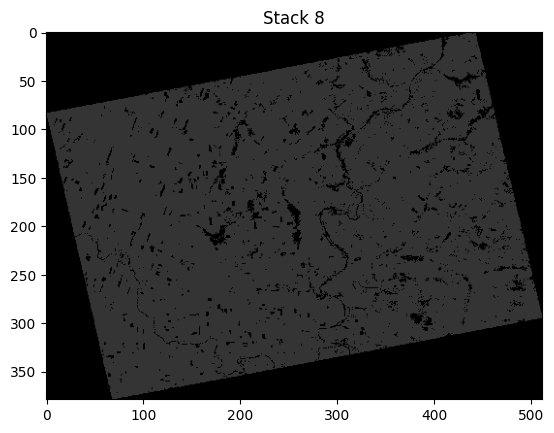

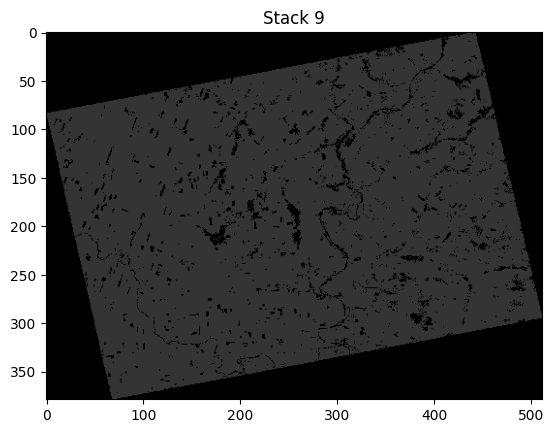

In [50]:
# Define the directory where your notebook is located
notebook_dir = os.getcwd()

# Define the paths to your training and ground truth images
stacked_images_dir = "/kaggle/working/stacked_images_updated"
ground_truth_dir = "/kaggle/input/ground-data"

training_data = []
training_labels = []

# Defining patch size
patch_size = 32

labels = [10, 50, 100, 150, 200, 250, 0]
thresholds = [0.35, 0.35, 0.35, 0.35, 0.35, 0.35, 0.35]

for year in range(2018, 2022):
    # Select the first image from the training set for the specified year
    training_image_path = os.path.join(stacked_images_dir, f"{year}_stacked.tif")
    ground_truth_path = os.path.join(ground_truth_dir, f"{year}.tif")

    # Calling Function to return labeled image
    labeled_image = process_images(training_image_path, ground_truth_path, labels, thresholds)
    training_data.append(labeled_image)

for i in range(labeled_image.shape[0]):
    plt.figure()
    plt.imshow(labeled_image[i, 0], cmap='tab20', vmin=0, vmax=250)
    plt.title(f"Stack {i + 1}")
    plt.show()

# Now, training_data and training_labels contain the patches and labels for each year's stacked image

In [51]:
for x in training_data:
    print(x.shape)

(9, 1, 379, 512, 3)
(9, 1, 379, 512, 3)
(9, 1, 379, 512, 3)
(9, 1, 379, 512, 3)


### Removing Singleton and Saving Images

In [52]:
output_folder = "masked"
os.makedirs(output_folder, exist_ok=True)

year = 2018
i=0

for img in training_data:
    img_without_singleton = np.squeeze(img)
    output_path = os.path.join(output_folder, f"{year+i}.tif")
    tiff.imwrite(output_path, img_without_singleton)
    i+=1
    

### Checking shape

In [53]:
# List of years for which you have saved stacked images
years = [2018, 2019, 2020, 2021]

# Iterate through the years and check the shape of the corresponding TIFF file
for year in years:
    tiff_file = f"/kaggle/working/masked/{year}.tif"
    try:
        # Open the TIFF file
        stacked_image = tiff.imread(tiff_file)
        
        # Get the shape of the stacked image
        shape = stacked_image.shape
        
        # Print the shape
        print(f"Year {year}: Shape = {shape}")
    except Exception as e:
        print(f"Year {year}: Unable to read TIFF file or file does not exist")

Year 2018: Shape = (9, 379, 512, 3)
Year 2019: Shape = (9, 379, 512, 3)
Year 2020: Shape = (9, 379, 512, 3)
Year 2021: Shape = (9, 379, 512, 3)


# 3. Model Design and Training

In [54]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization
from sklearn.metrics import mean_squared_error
from PIL import Image
import tensorflow as tf

### 3.1 Function for Loading and Normalizing the Data

In [67]:
def load_and_normalize_image(file_name):
    with Image.open(file_name) as img:
        # Initialize a list to store each image in the stack
        img_stack = []

        # Loop through each image in the .tif stack
        for i in range(img.n_frames):
            img.seek(i)
            img_array = np.array(img, dtype=np.float32)
            img_array /= 255.0  # Normalizing the image
            img_stack.append(img_array)

        # Stack all the images along the first dimension
        stacked_images = np.stack(img_stack, axis=0)

    return stacked_images

In [68]:
# Load training images (2018, 2019, 2020)
train_images = []
for year in range(2018, 2021):
    file_name = f"/kaggle/input/masked-data/{year}.tif"
    train_images.append(load_and_normalize_image(file_name))

train_images = np.array(train_images)

### Checking shape of each image in the loaded data

In [69]:
for x in train_images:
    print(x.shape)

(9, 379, 512, 3)
(9, 379, 512, 3)
(9, 379, 512, 3)


### Checking the loaded data

In [92]:
# for x in train_images:
#     plt.figure(figsize=(10, 5))
#     plt.subplot(1, 2, 1)
#     plt.imshow(x[0])

## 3.2 Designing and Training The Model

In [63]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2DTranspose
from sklearn.metrics import mean_squared_error
from PIL import Image
import matplotlib.pyplot as plt

### ConvLSTM2D Model

In [74]:
# Model Building
model = Sequential([
    ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', return_sequences=True,
               input_shape=(None, 379, 512, 3)),
    BatchNormalization(),
    TimeDistributed(Conv2DTranspose(filters=3, kernel_size=(3, 3), activation='sigmoid', padding='same'))
])

In [75]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [84]:
# Model Training
with tf.device('/GPU:0'):
    model.fit(train_images, train_images, epochs=30, batch_size=1)

Epoch 1/30
3/3 [==============================] - 2s 764ms/step - loss: 0.0483
Epoch 2/30
3/3 [==============================] - 2s 765ms/step - loss: 0.0369
Epoch 3/30
3/3 [==============================] - 2s 773ms/step - loss: 0.0268
Epoch 4/30
3/3 [==============================] - 2s 768ms/step - loss: 0.0187
Epoch 5/30
3/3 [==============================] - 2s 770ms/step - loss: 0.0125
Epoch 6/30
3/3 [==============================] - 2s 773ms/step - loss: 0.0081
Epoch 7/30
3/3 [==============================] - 2s 779ms/step - loss: 0.0052
Epoch 8/30
3/3 [==============================] - 2s 779ms/step - loss: 0.0034
Epoch 9/30
3/3 [==============================] - 2s 780ms/step - loss: 0.0023
Epoch 10/30
3/3 [==============================] - 2s 786ms/step - loss: 0.0016
Epoch 11/30
3/3 [==============================] - 2s 784ms/step - loss: 0.0012
Epoch 12/30
3/3 [==============================] - 2s 784ms/step - loss: 9.5715e-04
Epoch 13/30
3/3 [============================

### Forecasting

In [85]:
# Forecasting for 2021
with tf.device('/GPU:0'):
    predicted_2021 = model.predict(np.expand_dims(train_images[-1], axis=0))

1/1 [==============================] - 0s 48ms/step


In [86]:
# To check the shape of the predicted 2021 image
predicted_shape = predicted_2021.shape
print("Shape of the predicted 2021 image:", predicted_shape)

Shape of the predicted 2021 image: (1, 9, 379, 512, 3)


In [87]:
# Reshape the predicted image to (9, 379, 512, 3)
predicted_2021 = predicted_2021.reshape((9, 379, 512, 3))

In [88]:
# Load actual 2021 image for comparison
actual_2021 = load_and_normalize_image('/kaggle/input/masked-data/2021.tif')

# Calculate the accuracy using Mean Squared Error
mse = mean_squared_error(actual_2021.flatten(), predicted_2021.flatten())
accuracy = 100 - mse * 100  # Assuming accuracy as inverse of error

print(f"Model Accuracy: {accuracy}%")

Model Accuracy: 99.01224849745631%


### Saving the prediction

In [90]:
os.makedirs("predicted_sequence", exist_ok=True)

# Specify the file path where you want to save the TIFF file
file_path = 'predicted_sequence/predicted_2021.tif'

# Save the reshaped image as a TIFF file
tiff.imsave(file_path, predicted_2021)

/tmp/ipykernel_42/225487652.py:7: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(file_path, predicted_2021)


### Saving the model

In [94]:
model.save('conv_lstm_2d.h5')